<a href="https://colab.research.google.com/github/SimoneChiominto/TDA_grenoble/blob/main/BrainNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain functional network project


## Packages
First we import some libraries that will be useful in the project

### Install

In [1]:
#!pip install -U giotto-tda

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.


### Import

In [1]:
from numba import jit #utilising this library to speed up numpy computation
import numpy as np
import networkx as nx
import math
import gtda as gtda
from gtda.homology import VietorisRipsPersistence, SparseRipsPersistence, FlagserPersistence
from igraph import Graph
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
import pandas as pd
import os
import pickle

In [2]:
from random_graph_generation import *
from from_corr_to_graph import *
from filtration import *

### Importing datasets

In [3]:
#!git clone https://gricad-gitlab.univ-grenoble-alpes.fr/carbonil/regional-differentiation-based-on-graph-nodal-statistics-for-functional-brain-connectivity-networks-characterization.git
#!git clone https://github.com/SimoneChiominto/TDA_grenoble.git

fatal: il percorso di destinazione 'regional-differentiation-based-on-graph-nodal-statistics-for-functional-brain-connectivity-networks-characterization' esiste già e non è una directory vuota.
fatal: il percorso di destinazione 'TDA_grenoble' esiste già e non è una directory vuota.


## Giotto
let's try to compute persistence homology with giotto 

In [4]:
path="/content/regional-differentiation-based-on-graph-nodal-statistics-for-functional-brain-connectivity-networks-characterization/DATA/cor_mat_HCP_90"
files=os.listdir(path) #make a list of all the files' names at the path 
cor_mats_HCP_90_df=[pd.read_csv(path+"/"+file,delim_whitespace=True,header=None) for file in files]

Now I have imported all files in cor_mat_HCP_90. Let's do the same for the files in cor_mat_coma. They have a sligthly different structure

In [5]:
path="/content/regional-differentiation-based-on-graph-nodal-statistics-for-functional-brain-connectivity-networks-characterization/DATA/cor_mat_coma"
files=os.listdir(path) #make a list of all the files' names at the path 
cor_mats_coma_df=[pd.read_csv(path+"/"+file,delim_whitespace=True) for file in files]


Now we have imported all the correlation matrices as list of pandas dataframes.
Let's save them also as numpy arrays

In [6]:
cor_mats_HCP_90=[df.to_numpy() for df in cor_mats_HCP_90_df]
cor_mats_coma=[df.to_numpy() for df in cor_mats_coma_df]

### Compute some persistence diagrams

There I compute the persistance diagrams of the cor_mats in coma and save it in the file /data.diagrams_coma

In [ ]:
costs=np.linspace(1/44,1, 100)
diagrams_coma,VR_coma=custom_vietoris_persistance(cor_mats_coma,costs,[1,2,3,4],plot=False)

In [ ]:
VR_coma.plot(diagrams_coma, sample=9)

Now I want to save this data using pickle

In [ ]:
import pickle

In [ ]:
with open("/content/TDA_grenoble/data.diagrams_coma", "wb") as f:
  pickle.dump((diagrams_coma,VR_coma), f, protocol=pickle.HIGHEST_PROTOCOL)

NameError: ignored

In [9]:
with open("/content/TDA_grenoble/data.diagrams_coma","rb") as f:
  (diagrams_coma,VR_coma)=pickle.load(f)

FileNotFoundError: ignored

Now, I'll do the same as before with the HTC_90 Folder

In [ ]:
costs=np.linspace(1/44,1, 100)
diagrams_HCP_90,VR_HCP_90=custom_vietoris_persistance(cor_mats_HCP_90,costs,[1,2,3,4],plot=False)

KeyboardInterrupt: ignored

In [ ]:
VR_HCP_90.plot(diagrams_HCP_90, sample=9)

In [ ]:
with open("/content/TDA_grenoble/data.diagrams_HCP_90", "wb") as f:
  pickle.dump((diagrams_HCP_90,VR_HCP_90), f, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
with open("/content/TDA_grenoble/data.diagrams_HCP_90", "rb") as f:
  (diagrams_HCP_90,VR_HCP_90)=pickle.load(f)


In [22]:
VR_HCP_90.plot(diagrams_HCP_90,sample=0)

# New code
This are parts we are still working on

In [ ]:
G=np.loadtxt("WAVECO~1.TXT",skiprows=0,dtype=float,usecols=range(0,90))
print((G))

[[1.         0.82769115 0.57917623 ... 0.47048196 0.6871404  0.69223374]
 [0.82769115 1.         0.50612392 ... 0.5312735  0.55749886 0.63544121]
 [0.57917623 0.50612392 1.         ... 0.61353392 0.70573595 0.55755186]
 ...
 [0.47048196 0.5312735  0.61353392 ... 1.         0.57111876 0.60343518]
 [0.6871404  0.55749886 0.70573595 ... 0.57111876 1.         0.75000928]
 [0.69223374 0.63544121 0.55755186 ... 0.60343518 0.75000928 1.        ]]


In [ ]:
def custom_vietoris_persistance_old (adjacency_matrix,filtration_length,dimensions,plot):
  #commenti:  - cambierei il nome della variabile da adjacency a correlation matrix
  #           - più che filtration_lenght passerei i costi
  #           - con dimensions passerei già la lista delle dimensioni da calcolare, 
  #             magari con una cosa che conrtolla se è o no una lista se è una lista
  #             fa da uno a o altrimenti dai i costi
  #           - la funzione deve essere resistente a passare liste di correlation matrices, 
  #             così sfruttiamo la possibilità di giotto di calcolarne più insieme, 
  #             probabilmente in quella maniera è ottimizzato
  costs=np.linspace(1/44,1,filtration_length)
  graph_filtration=generate_graph_sequence(adjacency_matrix,costs)
  adjacency_matrix=from_filtration_to_adjacency(graph_filtration)
  dim = list(range(1,dimensions+1))
  print(dim)
  # Instantiate topological transformer
  VR = VietorisRipsPersistence(metric="precomputed",homology_dimensions=dim)
  adjacency_matrix=[adjacency_matrix]

  # Compute persistence diagrams corresponding to each graph in X
  diagrams = VR.fit_transform(adjacency_matrix)
  if(plot):
    VR.plot(diagrams, sample=0)
  return diagrams

In [ ]:
def custom_vietoris_persistance (corr_mats,costs,homology_dimensions,plot):
#qiesta è la versione che ho modificato, non riesco a stampare il grafico, cosa sbaglio??
#sposterei questo pezzo nella parte dedicata a giotto
  '''
  input:
    corr_mats:  correlation matrices of the graphs we want to compute the diagram
    costs:      list of the costs where the filtration is computed
    homology_dimensions: list of the dimensions of the homology to compute
    plot:       boolean value, if true this function plot the persistence graph 
  
  output:       diagrams, list of persistance diagrams. Each element of the list 
                is a list of points in the plane with associated dimansion
  '''  

  if isinstance(homology_dimensions, int):
    homology_dimensions=list(range(1,homology_dimensions+1))

  if not isinstance(corr_mats,list):
    corr_mats=[corr_mats]

  #generate filtrations
  graph_filtrations = [generate_graph_sequence(g,costs) for g in corr_mats] #sbaglia qualcosa qua dentro! fa soltanto 2 step
  #generate adjacency matrices
  adjacency_matrices = [from_filtration_to_adjacency(graph_filtration) for graph_filtration in graph_filtrations]
  # Instantiate topological transformer
  VR = VietorisRipsPersistence(metric="precomputed",homology_dimensions=homology_dimensions)
  # Compute persistence diagrams corresponding to each graph in X
  diagrams = VR.fit_transform(adjacency_matrices)
  print(diagrams)

  if (plot):
    VR.plot(diagrams, sample=0)
  return diagrams

example for testing purposes

In [ ]:
diagrams=custom_vietoris_persistance([G,G],[0.1,0.2,0.3,0.4],2,plot=True)

[array([[0., 0., 2., ..., 3., 0., 0.],
       [0., 0., 3., ..., 2., 2., 1.],
       [2., 3., 0., ..., 1., 0., 2.],
       ...,
       [3., 2., 1., ..., 0., 2., 1.],
       [0., 2., 0., ..., 2., 0., 0.],
       [0., 1., 2., ..., 1., 0., 0.]]), array([[0., 0., 2., ..., 3., 0., 0.],
       [0., 0., 3., ..., 2., 2., 1.],
       [2., 3., 0., ..., 1., 0., 2.],
       ...,
       [3., 2., 1., ..., 0., 2., 1.],
       [0., 2., 0., ..., 2., 0., 0.],
       [0., 1., 2., ..., 1., 0., 0.]])]


(not)working example

In [ ]:
diagrams=custom_vietoris_persistance(G,[1/44,1],[1,2,3,4],plot=True)
#print(G)

[[[0. 0. 1.]
  [0. 0. 2.]
  [0. 0. 3.]
  [0. 0. 4.]]]


ValueError: ignored

In [ ]:
diagrams=custom_vietoris_persistance_old(G,100,4,plot=True)
#print(G)

[[1.         0.82769115 0.57917623 ... 0.47048196 0.6871404  0.69223374]
 [0.82769115 1.         0.50612392 ... 0.5312735  0.55749886 0.63544121]
 [0.57917623 0.50612392 1.         ... 0.61353392 0.70573595 0.55755186]
 ...
 [0.47048196 0.5312735  0.61353392 ... 1.         0.57111876 0.60343518]
 [0.6871404  0.55749886 0.70573595 ... 0.57111876 1.         0.75000928]
 [0.69223374 0.63544121 0.55755186 ... 0.60343518 0.75000928 1.        ]]
[1, 2, 3, 4]


In [ ]:
betti_number_brain1=betti_numbers(diagrams,100)
print(betti_number_brain1)

[array([[0., 0., 0., 0.],
       [2., 0., 0., 0.],
       [4., 0., 0., 0.],
       [8., 0., 0., 0.],
       [7., 0., 0., 0.],
       [8., 0., 0., 0.],
       [5., 0., 0., 0.],
       [4., 1., 0., 0.],
       [3., 0., 0., 0.],
       [3., 0., 0., 0.],
       [3., 0., 0., 0.],
       [2., 0., 0., 0.],
       [2., 1., 0., 0.],
       [2., 1., 0., 0.],
       [2., 1., 0., 0.],
       [2., 1., 0., 0.],
       [2., 1., 0., 0.],
       [2., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [1., 0., 0., 0.],
       [2., 0., 0., 0.],
       [2., 0., 0., 0.],
       [2., 0., 0., 0.],
       [2., 0., 0., 0.],
       [2., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],

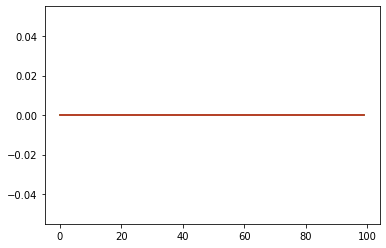

In [ ]:
#calcola i betti numbers con moltiplicità dato il diagramma)
plt.plot(range(100),betti_number_brain1[0])
#plt.plot(range(filtration_length),betti_number_erdos_renyi)
#plt.plot(range(filtration_length),y)
#plt.plot(range(filtration_length),erdos)
#y=[euler_entropy_cliques(graph) for graph in graph_filtration]
#plt.plot(range(filtration_length),entropy)
#betti_number
#entropy